## interplay between nucleosome repair, eviction/redeposition, and transcription
### nicole pagane | roberts lab

In [173]:
import scipy.integrate as snt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
pass

In [174]:
# declare universal constants
NUC_SPACE = 162
OCT_LEN = 147
HEX_LEN = 107
LOOP_OCT = 100
LOOP_HEX = 71
NUC_MOVE_OCT = 72
NUC_MOVE_HEX = NUC_MOVE_OCT*LOOP_HEX/LOOP_OCT

In [175]:
# initialize system without further knowledge of isw2 and isw1a mechanisms
# this is derived from results of statistical positioning

# intialize gene
def initializeGene(nucLen = OCT_LEN, avgSpace = NUC_SPACE, geneLen = 2000, constant = 0):
    gene = np.zeros(geneLen)
    ind = 0
    nucNum = 1
    while ind + nucLen < geneLen:
        gene[ind:ind+nucLen] = nucNum
        if constant: 
            spc = constant
        else:
            k = -np.log(0.5)
            y = avgSpace*0.5*np.exp(-k*(ind+nucLen)/geneLen)
            spc = int(avgSpace*1.5 - y)
        ind = ind + nucLen + spc
        nucNum += 1
    return gene

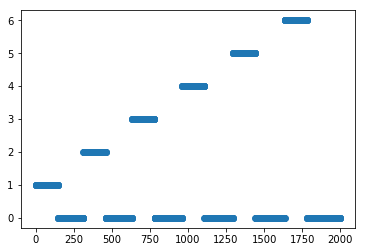

In [180]:
gene = initializeGene()
plt.plot(gene, 'o')
plt.show()

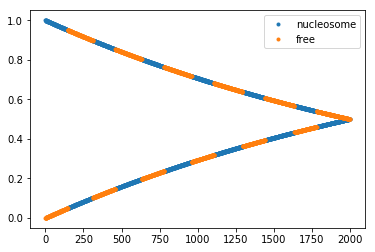

In [89]:
# define gene occupancy expectation
def geneOccupancy(g):
    x = np.linspace(1, len(g), len(g))
    k = -np.log(0.5)
    y = np.exp(-k*x/len(g))
    gScale = np.ceil(g/max(g))*y
    for i in range(len(g)):
        if gScale[i] == 0:
            gScale[i] = 1-y[i]
    return gScale


gRef = geneOccupancy(initializeGene())
plt.plot(gRef, '.', label='nucleosome')
plt.plot(1-gRef, '.', label='free')
plt.legend()
plt.show()

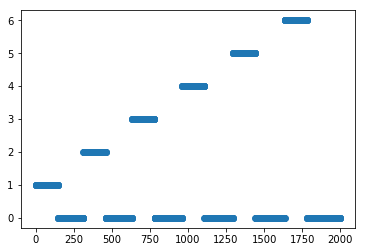

{0.0: 0, 1.0: 167, 2.0: 174, 3.0: 182, 4.0: 188, 5.0: 194, 6.0: 219}


In [90]:
# determine spacing
def detSpace(g):
    gene = np.linspace(0, len(g)-1, len(g))
    space = {}
    nucs = np.unique(g)
    for i in range(len(nucs)):
        lowBound = np.asarray(gene[g==nucs[i-1]], int)
        if nucs[i-1] == 0: lowBound = [0];
        space[nucs[i-1]] = np.asarray(gene[g==nucs[i]], int)[0] - lowBound[-1]
    # append last nuc spacing to end of gene
    space[nucs[-1]] = len(g) - np.asarray(gene[g==nucs[-1]], int)[-1]
    return space

plt.plot(gene, 'o')
plt.show()
print detSpace(gene)

In [91]:
# define energy calculation
def energy(g):
    '''
    # OLD energy
    # determine spacing
    space = detSpace(g).values()
    # compare to exponential distribution
    x = np.linspace(0, len(space)-1, len(space))
    y = NUC_SPACE*np.exp(-x*1.0/len(space)) 
    dist = (y-space)**2
    # bias the weighting to fit the beginning of the nucleosome better
    dist = np.sum(dist*np.exp(-3*x/(len(space)))) # factor of 3 decided randomly tbh
    return dist/len(g)
    '''
    # NEW energy
    dist = (gRef - np.ceil(g/max(g)))**2 # taking into account occupancy at site
    # scale to fit 3prime end better 
    #k = -np.log(0.5); x = np.linspace(0, len(g)-1, len(g))
    #dist = np.sum(dist*np.exp(-k*x/(len(g)))) # factor of 3 decided randomly tbh
    return np.sum(dist)/len(g)

TODO
* min abs linker length to allow remodelers
* actual energy that could be some spring ?? or affinity by sequence ??

In [92]:
# MCMC to simulate nucleosome shuffling
def MCMC(g = initializeGene(), N = 1000, BF = 1e-3):
    N = int(N)
    gRef = geneOccupancy(g)
    nucN = max(g)
    curE = energy(g)
    eVec = []
    propG = np.zeros(len(g))
    gSum = np.ceil(g/max(g))
    for i in range(N):
        # select random nucleosome
        propNuc = np.random.randint(min(g)+1, nucN+1)
        propInd = np.array(np.linspace(0, len(g)-1, len(g))[g == propNuc], int)
        # select random movement
        propMove = int(np.random.normal(0, np.sqrt(NUC_SPACE))) # sample from normal w spread nuc len
        # implement proposed movement
        move = propInd + propMove
        moveTrim = move[move >= 0]
        move = moveTrim[moveTrim < len(g)]
        # check for collision
        propG = g[:]*1.0 # shallow copy
        propG[propInd] = 0
        if (np.sum(propG[move]) == 0 and len(move) == len(propInd)):
            propG[move] = propNuc
            # metropolis criterion
            propE = energy(propG)
            delE = propE - curE
            rand = np.random.rand()
            if (rand < np.exp(-delE/BF)):
                # accept change
                g = propG[:]*1.0 #shallow copy
                curE = propE
                if (nucN != max(g)):
                    gRef = geneOccupancy(g) # reset reference state
                    nucN = max(g)
            gSum += np.ceil(g/max(g))
            eVec.append(curE)
    return g, eVec, gSum

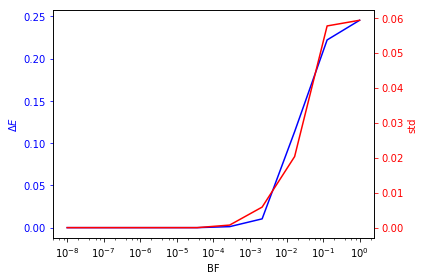

In [93]:
# determining best BF for dummy energy term
BF = np.logspace(-8,0, 10)

delE = []
std = []
for i in BF:
    gene, eVec, null = MCMC(BF = i)
    delE.append(eVec[-1] - eVec[0])
    std.append(np.std(eVec))

    
fig, ax1 = plt.subplots()
ax1.plot(BF, delE, 'b-')
ax1.set_xlabel('BF')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\Delta E$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(BF, std, 'r-')
ax2.set_ylabel('std', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.show()

In [94]:
gene = initializeGene(constant = NUC_SPACE)

n1 = 1000; n2 = 5000; n3 = 10000
T = 5e-3
gene1, eVec1, gA1= MCMC(gene, n1, T)
gene2, eVec2, gA2 = MCMC(gene, n2, T)
gene3, eVec3, gA3 = MCMC(gene, n3, T)

allowed moves for 1: 953
allowed moves for 2: 4710
allowed moves for 3: 9412


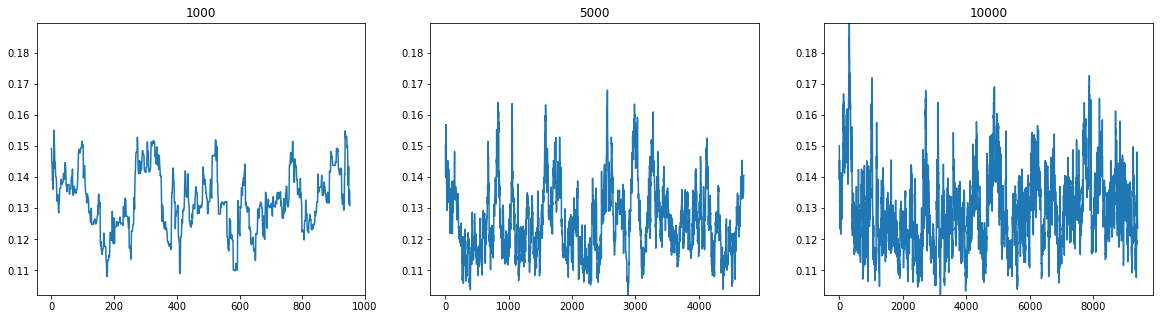

In [95]:
print 'allowed moves for 1: ' + str(len(eVec1))
print 'allowed moves for 2: ' + str(len(eVec2))
print 'allowed moves for 3: ' + str(len(eVec3))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_ylim([min(eVec3), max(eVec3)])
ax.set_title(n1)
ax.plot(eVec1)
ax = fig.add_subplot(1,3,2)
ax.set_ylim([min(eVec3), max(eVec3)])
ax.set_title(n2)
ax.plot(eVec2)
ax = fig.add_subplot(1,3,3)
ax.set_ylim([min(eVec3), max(eVec3)])
ax.set_title(n3)
ax.plot(eVec3)

plt.show()

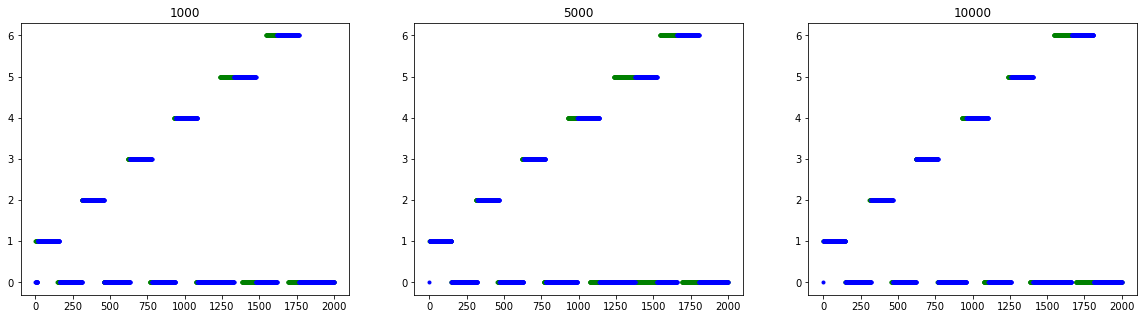

In [96]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gene, 'g.')
ax.plot(gene1, 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gene, 'g.')
ax.plot(gene2, 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gene, 'g.')
ax.plot(gene3, 'b.')

plt.show()

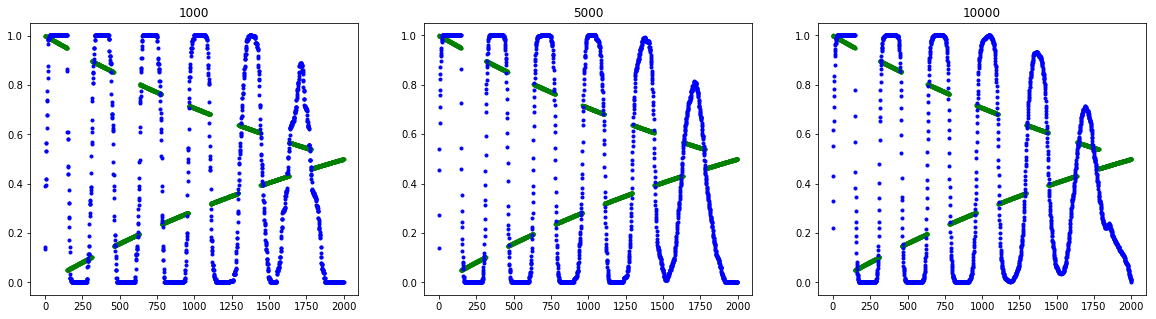

In [97]:
# reference
gRef = geneOccupancy(initializeGene())

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gRef, 'g.')
ax.plot(gA1/len(eVec1), 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gRef, 'g.')
ax.plot(gA2/len(eVec2), 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gRef, 'g.')
ax.plot(gA3/len(eVec3), 'b.')

plt.show()

In [98]:
print detSpace(gene)
print ''
print detSpace(gene1)
print detSpace(gene2)
print detSpace(gene3)

{0.0: 0, 1.0: 163, 2.0: 163, 3.0: 163, 4.0: 163, 5.0: 163, 6.0: 309}

{0.0: 14, 1.0: 153, 2.0: 174, 3.0: 159, 4.0: 245, 5.0: 143, 6.0: 236}
{0.0: 1, 1.0: 175, 2.0: 163, 3.0: 215, 4.0: 240, 5.0: 135, 6.0: 195}
{0.0: 1, 1.0: 173, 2.0: 156, 3.0: 191, 4.0: 154, 5.0: 259, 6.0: 190}


TODO
* change everything lol
* energy calculation depdendent on torsion ??
* nucloesomes moved through disslocation upstream not diffusion 

In [99]:
# probs from paper 
kue = 1; N = 40; Nt = 147; kt = 0.02; kd = 0.027
phex = (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N)) - (kue/(kt+kue))**Nt
poct = 1.0 - (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N))
pfree = (kue/(kt+kue))**Nt

print 'prob of hex: ', phex*100 
print 'prob of oct: ', poct*100
print 'prob of free: ', pfree*100

prob of hex:  20.7163647036
prob of oct:  73.8414321259
prob of free:  5.44220317046


In [488]:
Nun = 40
baseoct = OCT_LEN/2.0 - Nun
basehex = HEX_LEN/2.0 - Nun

# define RNAP passage effects
def RNAP(g):
    spc = detSpace(g)
    nucs = spc.keys()
    # attempt +1 nuc alteration (without upstream move)
    nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[1]], int)
    if (np.sum(1 == g) == OCT_LEN):
        # randomly determine fate of octomer from above probabilities
        rand = np.random.random()
        if rand < pfree: # remove octomer
            temp = g[:]*1.0
            temp[nuc] = 0
        elif rand < (pfree+phex): # lose dimer and move upstream
            temp = g[:]*1.0
            temp[nuc] = 0
            # shave off sides
            side = (OCT_LEN-HEX_LEN)/2
            nuc = np.linspace(min(nuc)+side, max(nuc)-side, HEX_LEN, dtype = int)
            temp[nuc] = g[nuc]
    elif (np.sum(1 == g) == HEX_LEN):
        # randomly determine fate of octomer from above probabilities
        rand = np.random.random()
        if rand < pfree/(pfree+phex): # remove hexasome (reweighted probs)
            temp = g[:]*1.0
            temp[nuc] = 0
    # attempt movement on the rest of the nucleosomes
    i = 1
    while (i < len(spc)-1):
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i+1]], int)
        dist = spc
        if (spc[nucs[i]] >= LOOP_OCT and np.sum(nucs[i+1] == g) == OCT_LEN): # octosome
            # randomly determine fate of octomer from above probabilities
            rand = np.random.random()
            if rand < pfree: # remove octomer
                temp = g[:]*1.0
                temp[nuc] = 0
            elif rand < (pfree+phex): # lose dimer and move upstream
                temp = g[:]*1.0
                temp[nuc] = 0
                # shave off sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.linspace(min(nuc)+side, max(nuc)-side, HEX_LEN, dtype = int)
                temp[nuc - NUC_MOVE_HEX] = g[nuc]
            else: # move upstream as octomer
                temp = g[:]*1.0
                temp[nuc] = 0
                temp[nuc - NUC_MOVE_OCT] = g[nuc]
        elif (spc[nucs[i]] >= LOOP_HEX and np.sum(nucs[i+1] == g) == HEX_LEN): # hexasome
             # randomly determine fate of octomer from above probabilities
                rand = np.random.random()
                if rand < pfree/(pfree+phex): # remove hexasome (reweighted probs)
                    temp = g[:]*1.0
                    temp[nuc] = 0
                else: # move hexasome
                    temp = g[:]*1.0
                    temp[nuc] = 0
                    temp[nuc - NUC_MOVE_HEX] = g[nuc]
        else: # remove nucleosome due to crowding or make hexasome
            temp = g[:]*1.0
            temp[nuc] = 0
        g = temp
        i += 1
        spc = detSpace(g)
        nucs = spc.keys()
    return g

In [489]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g); gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    print 'transcription ', i+1, ': ', detSpace(g).values()
    g, e, gA = MCMC(g, 1000, T); gene.append(g); en.extend(e); gAv.append(gA/len(e))
    print 'relaxation ', i+1, ': ', detSpace(g).values(), ' with ', len(e), ' attempts'

transcription  1 :  [0, 95, 174, 182, 188, 194, 291]
relaxation  1 :  [7, 176, 162, 177, 179, 150, 273]  with  954  attempts
transcription  2 :  [7, 104, 162, 177, 179, 150, 345]
relaxation  2 :  [0, 170, 174, 159, 240, 287, 94]  with  946  attempts
transcription  3 :  [0, 98, 174, 159, 240, 287, 166]
relaxation  3 :  [0, 162, 192, 187, 169, 181, 233]  with  937  attempts
transcription  4 :  [0, 131, 191, 187, 169, 181, 305]
relaxation  4 :  [12, 153, 226, 174, 203, 165, 231]  with  944  attempts
transcription  5 :  [12, 102, 205, 174, 203, 206, 302]
relaxation  5 :  [9, 143, 235, 137, 192, 256, 232]  with  958  attempts
transcription  6 :  [9, 92, 214, 178, 191, 277, 283]
relaxation  6 :  [2, 168, 201, 207, 194, 322, 150]  with  927  attempts
transcription  7 :  [2, 117, 180, 228, 214, 342, 201]
relaxation  7 :  [16, 175, 183, 252, 218, 295, 145]  with  951  attempts
transcription  8 :  [16, 124, 162, 273, 670, 145]
relaxation  8 :  [9, 158, 198, 191, 753, 81]  with  944  attempts
tra

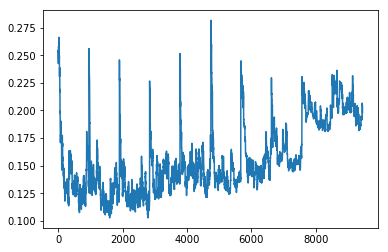

In [490]:
plt.plot(en)
plt.show()

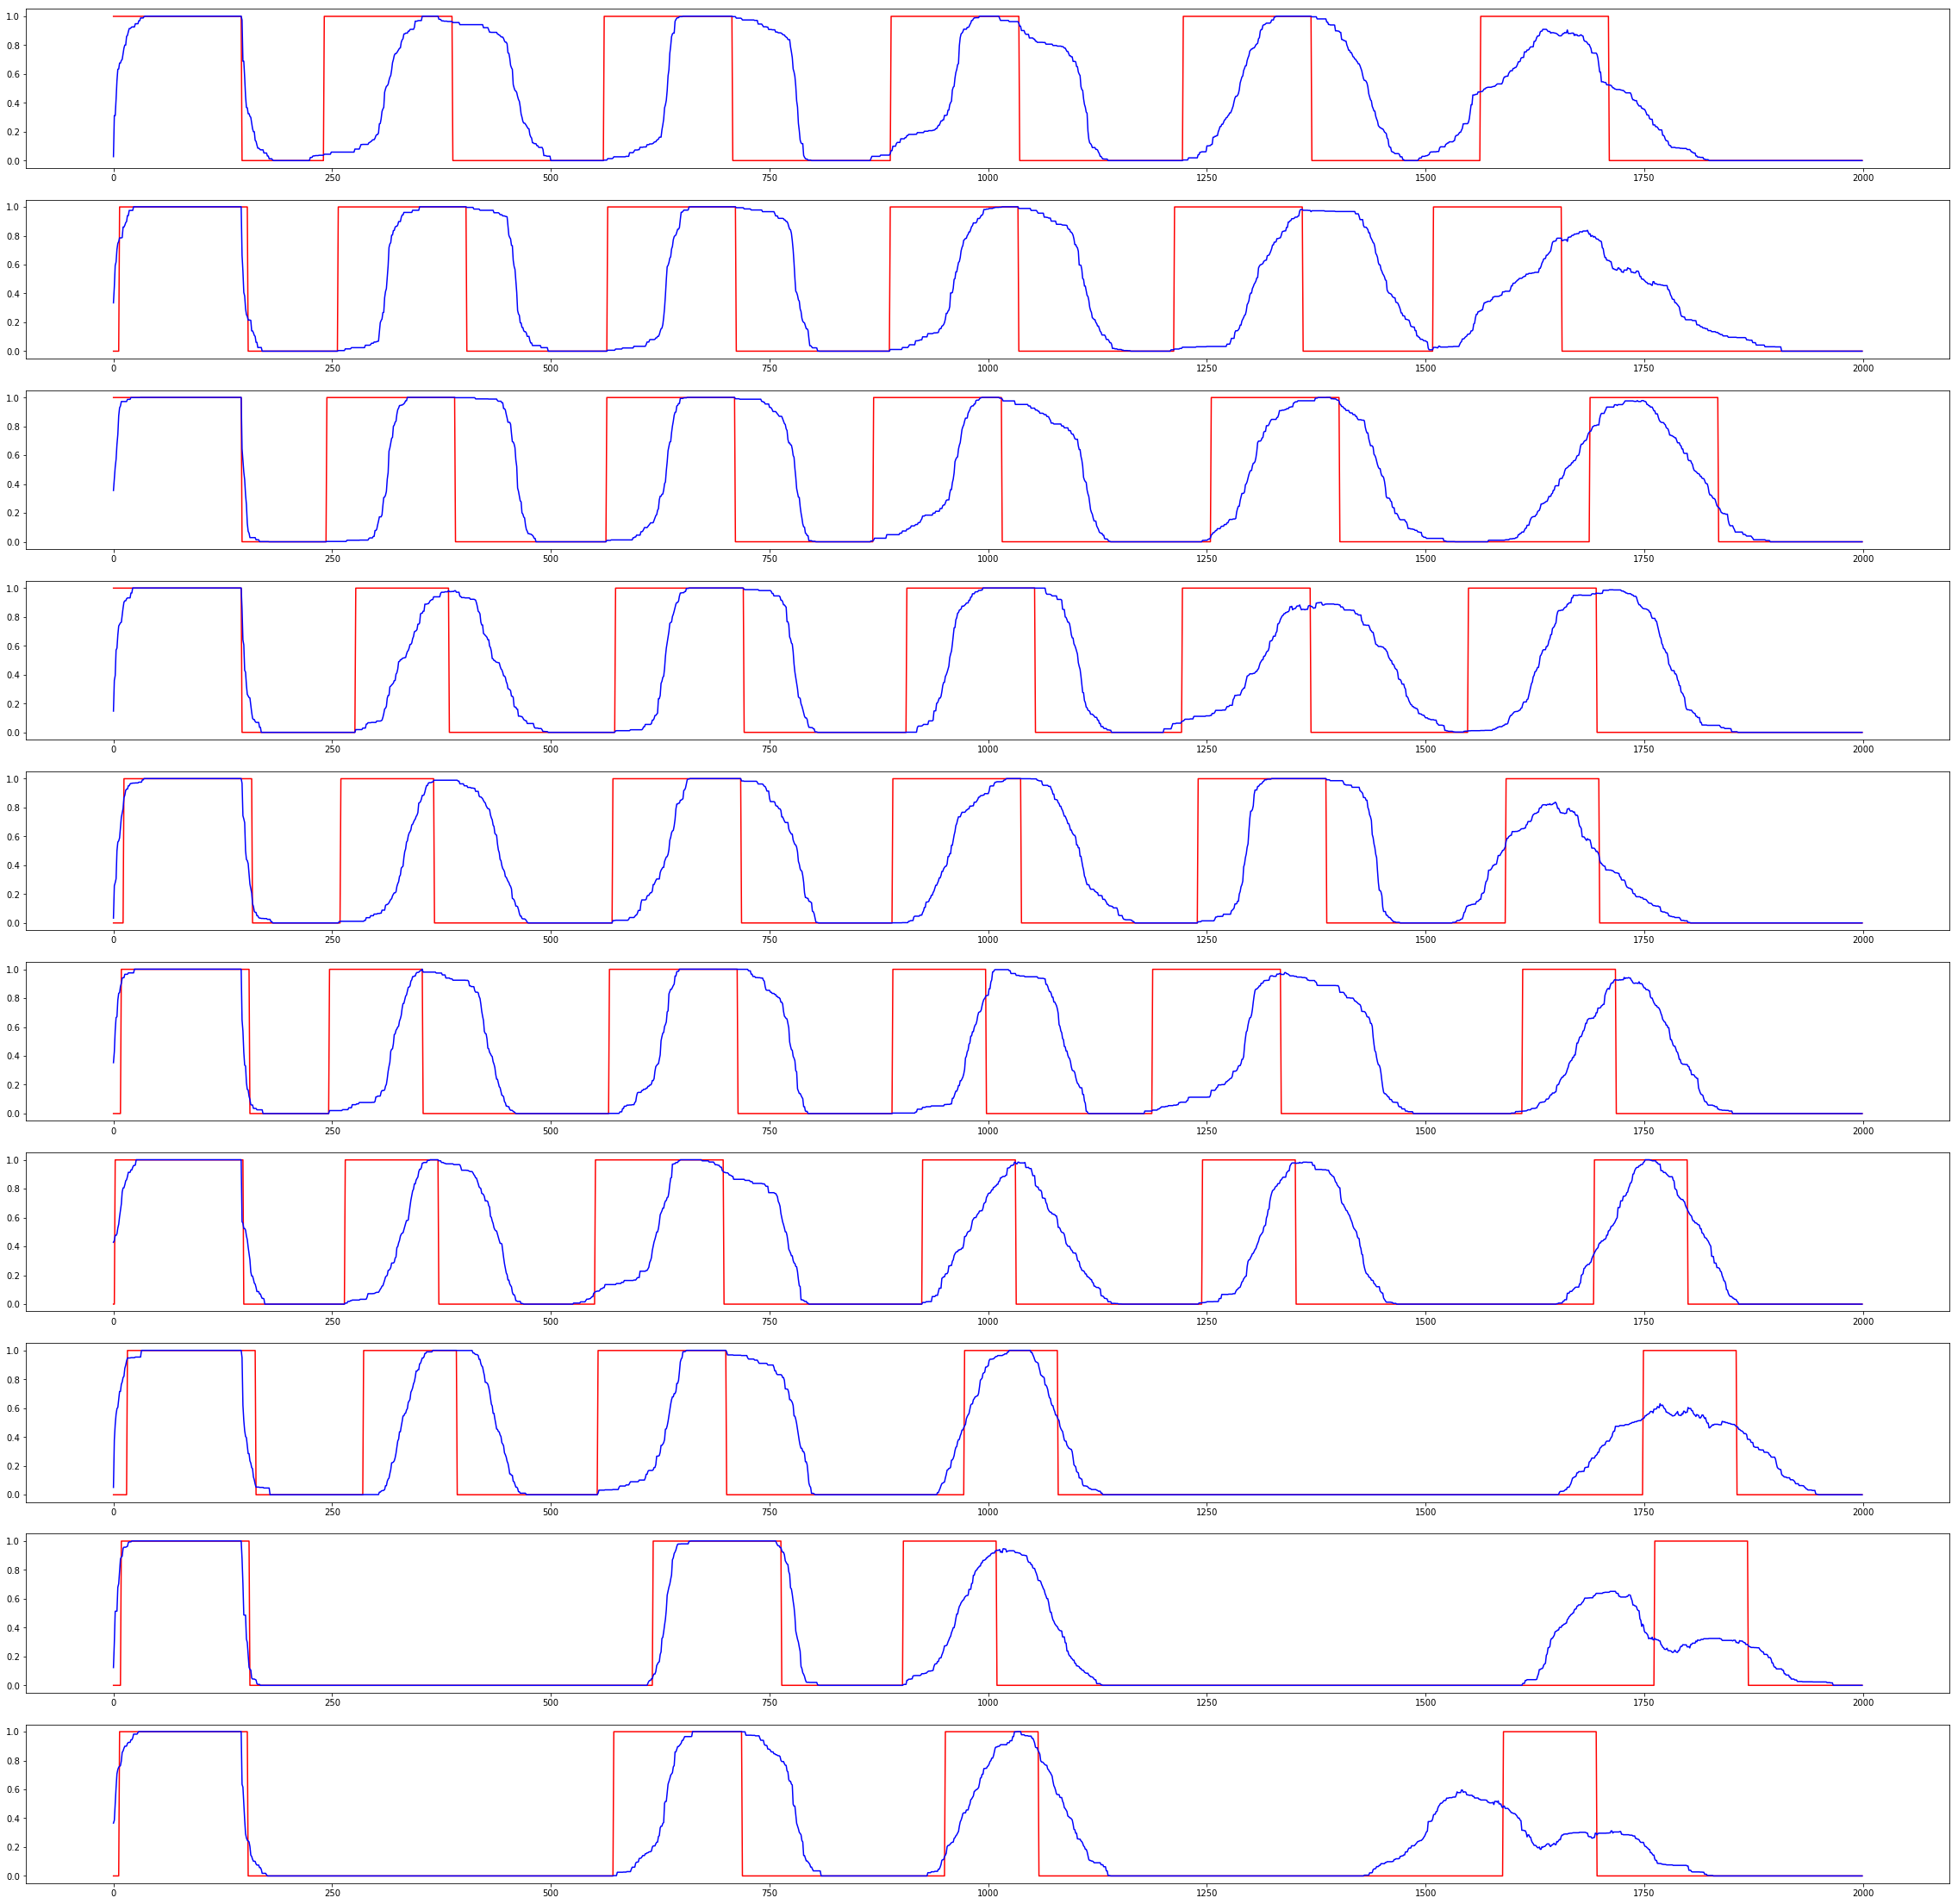

In [491]:
fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

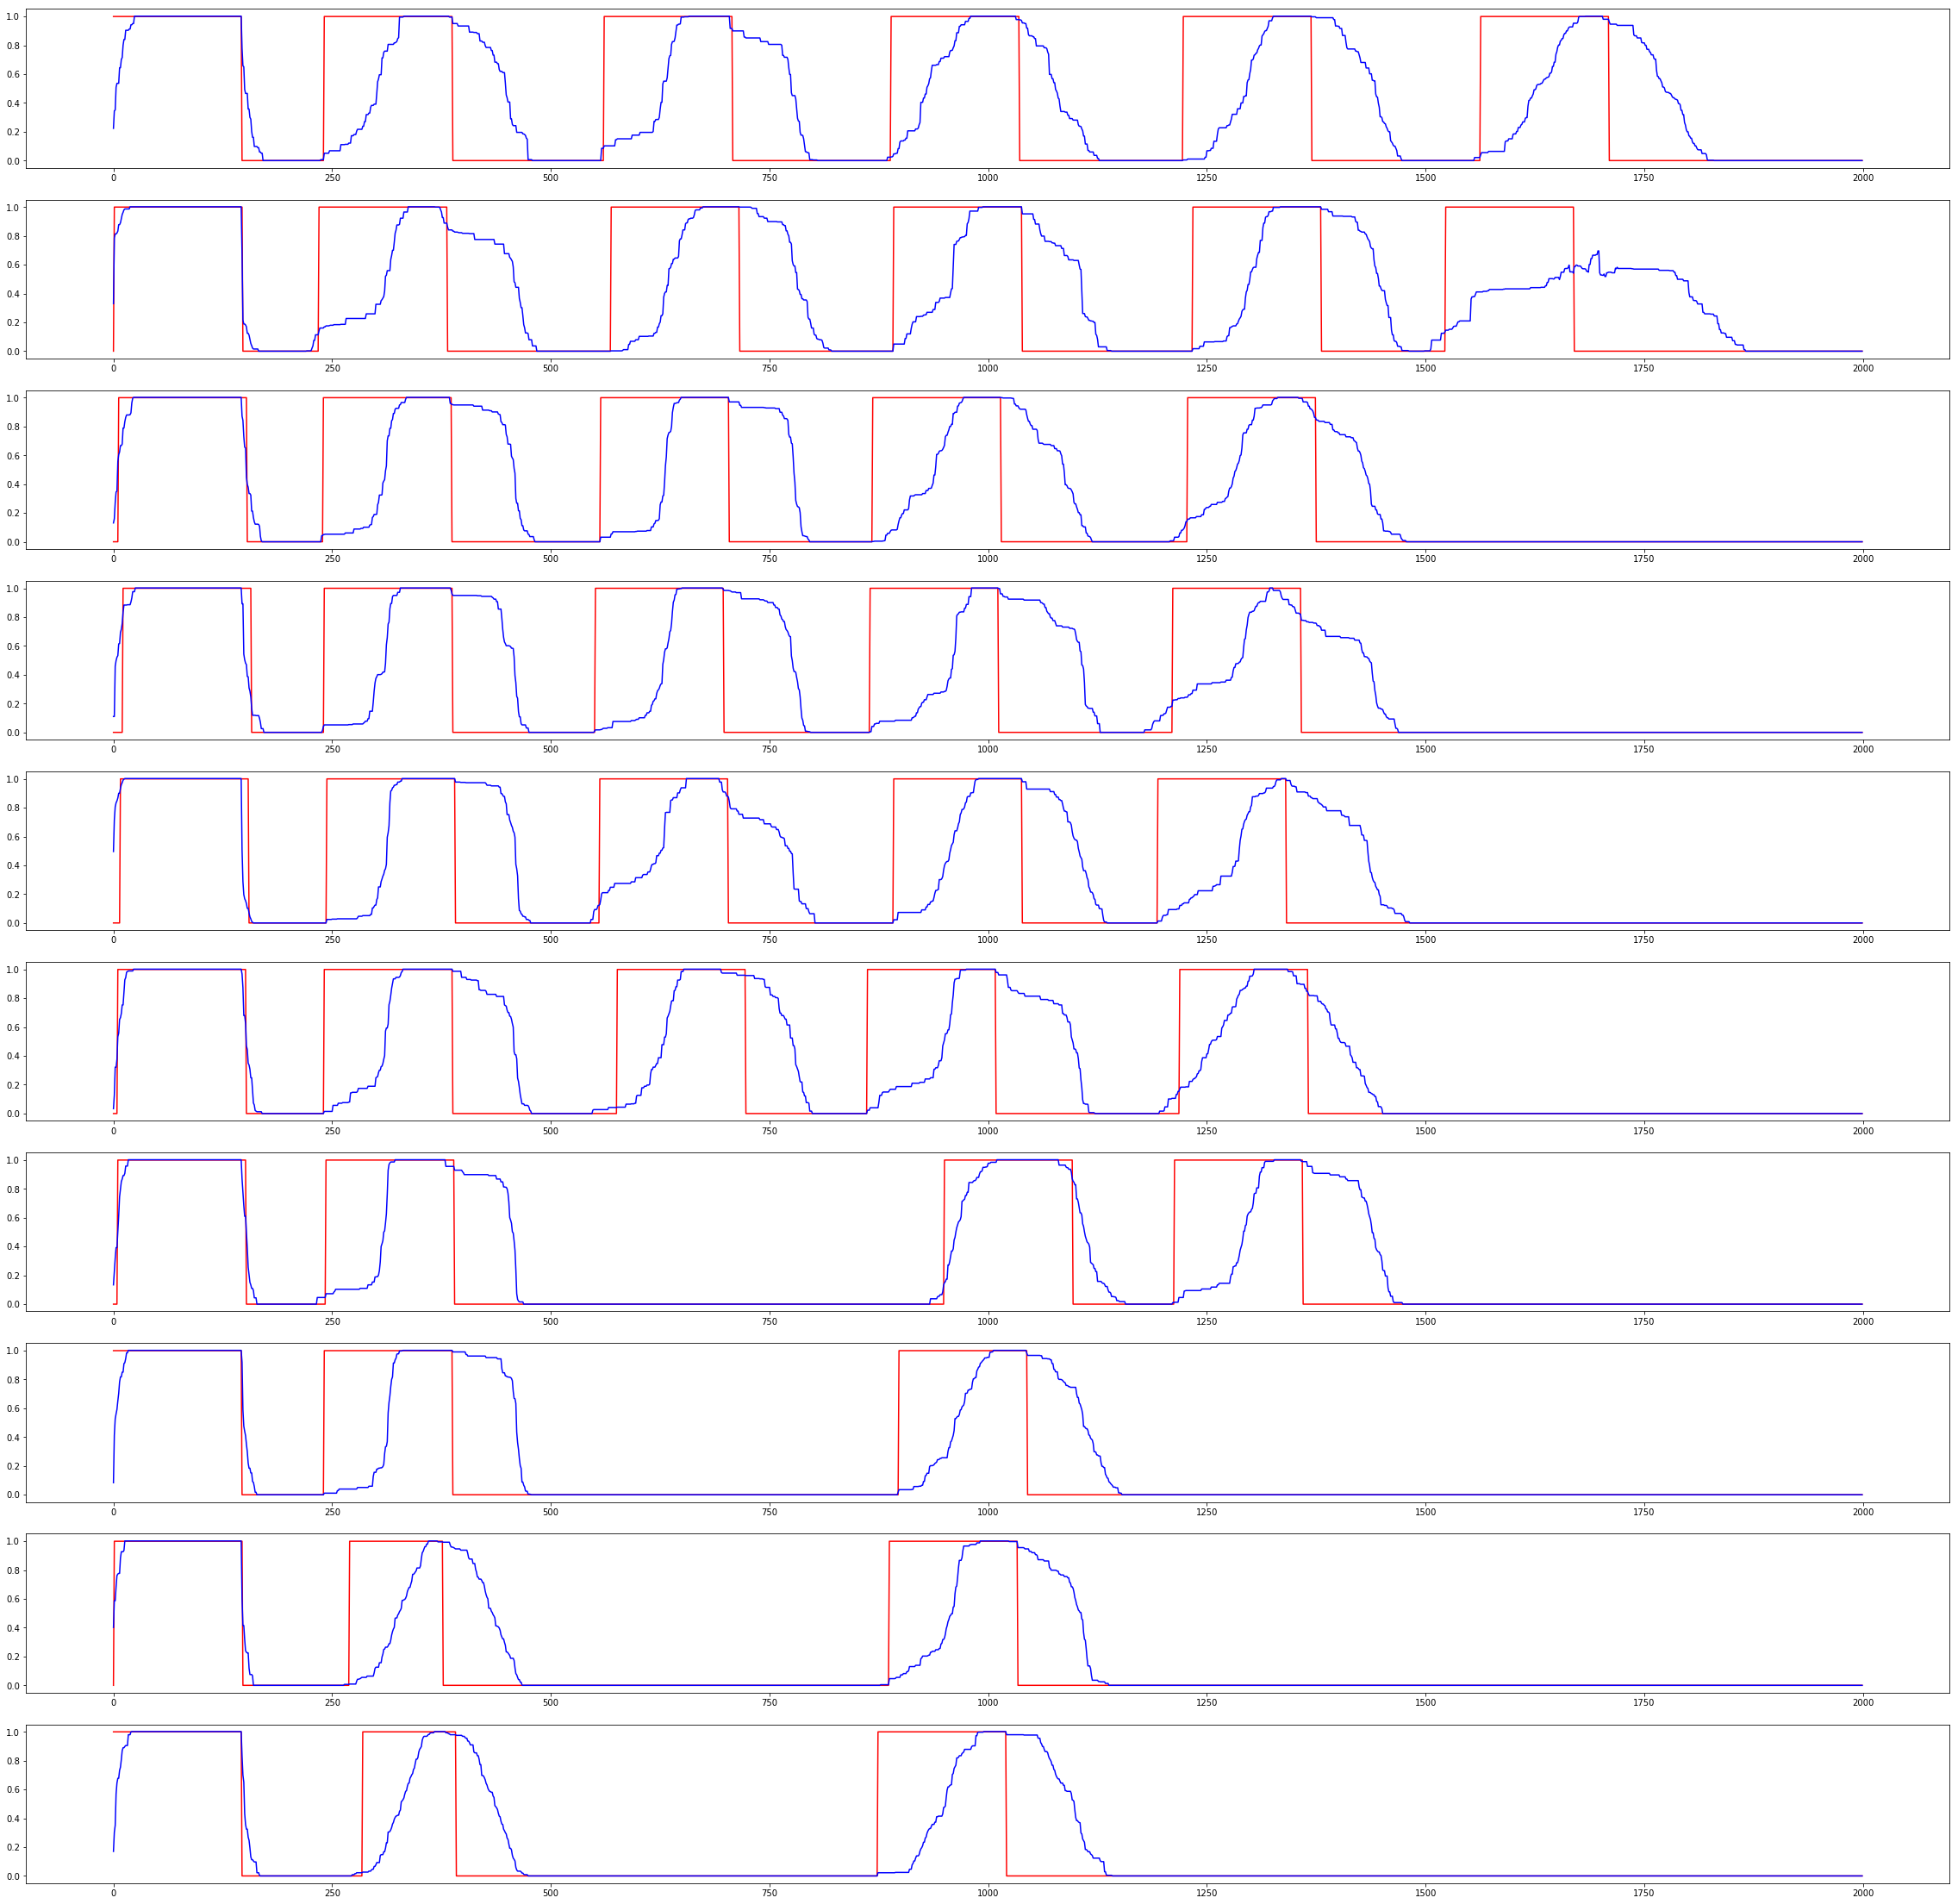

In [492]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g); gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 500, T); gene.append(g); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [479]:
# run several simulations varying transcription rate to gather statistics
runs = {}
cycles = 5
reps = 20
geneLen = 2000
pts = 25

for trate in np.linspace(10,500,25):
    gene = np.zeros(geneLen); avgOcc = np.zeros(geneLen*2*cycles).reshape([2*cycles, geneLen]); avgE = [];
    for rep in range(reps):
        en = []
        g = initializeGene()
        gAv = []
        for i in range(cycles):
            g = RNAP(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
            g, e, gA = MCMC(g, int(trate), T); en.extend(e); gAv.append(gA/len(e))
        gene += np.asarray(g)/reps; avgOcc += np.asarray(gAv)/reps; avgE.append(en);
    runs[int(trate)] = [gene, avgOcc, avgE]
    print reps, ' sims for MCMC iter ', int(trate), ' done'
print 'done'

20  sims for MCMC iter  10  done
20  sims for MCMC iter  30  done
20  sims for MCMC iter  50  done
20  sims for MCMC iter  71  done
20  sims for MCMC iter  91  done
20  sims for MCMC iter  112  done
20  sims for MCMC iter  132  done


KeyboardInterrupt: 

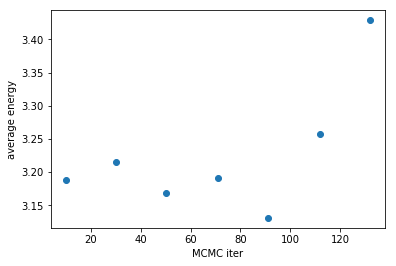

In [480]:
# plot energy
en = []
trate = []
count = 0
for i in runs.keys():
    trate.append(i)
    en.append(0)
    for j in range(len(runs[i][1])):
        en[count] += sum(runs[i][1][j])/len(runs[i][1][j])
    count += 1
    
plt.plot(trate,en, 'o')
plt.xlabel('MCMC iter'); plt.ylabel('average energy')
plt.show()

In [460]:
# how many nucs remain?
nucs = []
trate = []
for i in runs.keys():
    trate.append(i)
    nucs.append(sum(runs[i][0][-1]))
    
plt.plot(trate,nucs, 'o')
plt.xlabel('MCMC iter'); plt.ylabel('remaining nucs')
plt.show()

TypeError: 'numpy.float64' object is not iterable

In [432]:
print sum(runs[193][0][-1])
plt.plot(runs[193][0][-1] )
plt.show()

TypeError: 'numpy.float64' object is not iterable